This quickstart notebook allows to test and mess around with the MLPF GNN model in a standalone way. For actual training, we don't use a notebook, please refer to `README.md`.


```bash
git clone https://github.com/jpata/particleflow/
```

Run the notebook from `notebooks/delphes-tf-mlpf-quickstart.ipynb`.

In [2]:
import bz2, pickle
import numpy as np
import tensorflow as tf
import sklearn
import sklearn.metrics
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path += ["/home/sraj/Documents/May2022/UCSD/particleflow/mlpf"]

In [4]:
import tfmodel

In [5]:
!wget --no-check-certificate -nc https://zenodo.org/record/4452283/files/tev14_pythia8_ttbar_0_0.pkl.bz2

File ‘tev14_pythia8_ttbar_0_0.pkl.bz2’ already there; not retrieving.



In [6]:
data = pickle.load(bz2.BZ2File("tev14_pythia8_ttbar_0_0.pkl.bz2", "r"))

In [7]:
#100 events in one file
len(data["X"]), len(data["ygen"])

(100, 100)

In [8]:
#Pad the number of elements to a size that's divisible by the bin size
Xs = []
ys = []

max_size = 50*128
for i in range(len(data["X"])):
    X = data["X"][i][:max_size, :]
    y = data["ygen"][i][:max_size, :]
    Xpad = np.pad(X, [(0, max_size - X.shape[0]), (0, 0)])
    ypad = np.pad(y, [(0, max_size - y.shape[0]), (0, 0)])
    Xpad = Xpad.astype(np.float32)
    ypad = ypad.astype(np.float32)
    Xs.append(Xpad)
    ys.append(ypad)
    
X = np.stack(Xs)
y = np.stack(ys)

In [9]:
#Get the first event
input_classes = np.unique(X[:, :, 0].flatten())
output_classes = np.unique(y[:, :, 0].flatten())
num_output_classes = len(output_classes)

In [10]:
input_classes

array([0., 1., 2.], dtype=float32)

In [11]:
output_classes

array([0., 1., 2., 3., 4., 5.], dtype=float32)

In [12]:
def transform_target(y):
    return {
        "cls": tf.one_hot(tf.cast(y[:, :, 0], tf.int32), num_output_classes),
        "charge": y[:, :, 1:2],
        "pt": y[:, :, 2:3],
        "eta": y[:, :, 3:4],
        "sin_phi": y[:, :, 4:5],
        "cos_phi": y[:, :, 5:6],
        "energy": y[:, :, 6:7],
    }
yt = transform_target(y)

2022-06-07 16:50:52.710373: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-07 16:50:52.710426: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sraj-OptiPlex-5050): /proc/driver/nvidia/version does not exist
2022-06-07 16:50:52.711097: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
from tfmodel.model import PFNetDense

In [14]:
msk_true_particle = y[:, :, 0]!=0

In [15]:
np.unique(y[msk_true_particle][:, 0], return_counts=True)

(array([1., 2., 3., 4., 5.], dtype=float32),
 array([263996,  93508, 133732,    912,    278]))

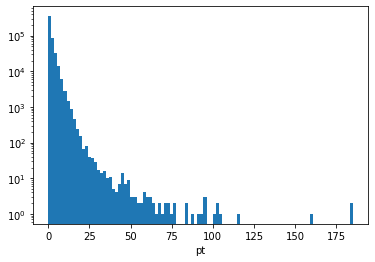

In [16]:
plt.hist(yt["pt"][msk_true_particle].flatten(), bins=100);
plt.xlabel("pt")
plt.yscale("log")

Text(0.5, 0, 'eta')

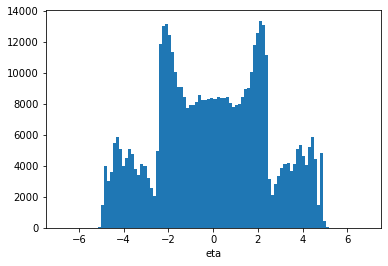

In [17]:
plt.hist(yt["eta"][msk_true_particle].flatten(), bins=100);
plt.xlabel("eta")

Text(0.5, 0, 'sin phi')

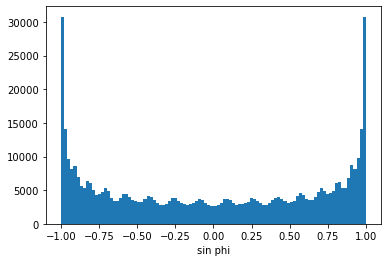

In [18]:
plt.hist(yt["sin_phi"][msk_true_particle].flatten(), bins=100);
plt.xlabel("sin phi")

Text(0.5, 0, 'cos phi')

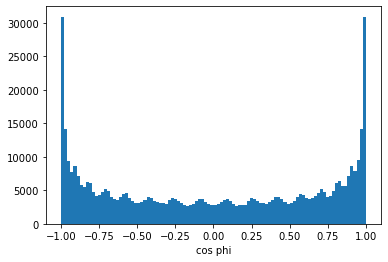

In [19]:
plt.hist(yt["cos_phi"][msk_true_particle].flatten(), bins=100);
plt.xlabel("cos phi")

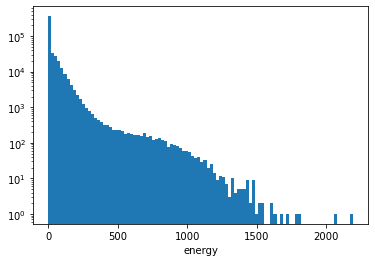

In [20]:
plt.hist(yt["energy"][msk_true_particle].flatten(), bins=100);
plt.xlabel("enem typing import Optional, Unionrgy")
plt.yscale("log")

In [23]:
model = PFNetDense(
    num_input_classes=len(input_classes),
    num_output_classes=len(output_classes),
    activation=tf.nn.elu,
    hidden_dim=128,
    bin_size=128,
    input_encoding="default",
    multi_output=True
)

# #temporal weight mode means each input element in the event can get a separate weight
model.compile(
    loss={
        "cls": tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        "charge": tf.keras.losses.MeanSquaredError(),
        "pt": tf.keras.losses.MeanSquaredError(),
        "energy": tf.keras.losses.MeanSquaredError(),
        "eta": tf.keras.losses.MeanSquaredError(),
        "sin_phi": tf.keras.losses.MeanSquaredError(),
        "cos_phi": tf.keras.losses.MeanSquaredError()
    },
    optimizer="adam",
    sample_weight_mode="temporal"
)

TypeError: getattr(): attribute name must be string

In [ ]:
model(X[:1])

In [ ]:
model.fit(X, yt, epochs=2, batch_size=5)

In [ ]:
ypred = model.predict(X, batch_size=5)

In [ ]:
#index of the class prediction output values
pred_id_offset = len(output_classes)
ypred_ids_raw = ypred["cls"]

In [ ]:
sklearn.metrics.confusion_matrix(
    np.argmax(ypred_ids_raw, axis=-1).flatten(),
    np.argmax(yt["cls"], axis=-1).flatten(), labels=output_classes
)

In [ ]:
msk_particles = (X[:, :, 0]!=0)
plt.scatter(
    ypred["eta"][msk_particles].flatten(),
    yt["eta"][msk_particles].flatten(), marker=".")